# 1. Data Description
There are 3 major data source from this data set:
1. Trap data: ranges from 2007-2013. Training data are odd years (2007, 2009, 2011 and 2013) and test set come from even years (2008, 2010, 2012 and 2014). 
2. Spray data: only available for 2011 and 2013. Just because only 2 years spray data is available to me, it doesn't mean spraying wasn't performed in the rest of the years.<br> It will be hard to use this information to train the model because I don't have the spray information for the test set. However, I can search on web to look for this additional information and if there's no luck I can perform a qualitative analysis on the effects of spray. 
3. Weather: available from May to Oct in 2007-1014, on a daily basis from two stations around Chicago. It would be really nice to know where the stations are located.

### Target and metric:
For each record in the test set, you should predict a real-valued probability that WNV is present. Results are evaluated on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes.<br>
While the record in the test set are the information of the location and time of the year, the task of this study can be summurized as forecasting the regional and seasonal risk of WNV outbreak. 

### Domain knowledge
- Info on Aerial Spraying: https://www.cdc.gov/westnile/vectorcontrol/aerial-spraying.html
- Mosquitoes contracted WNV:<br>
Despite the reach of the disease, not all mosquitoes carry West Nile Virus, mitigating the risk of transmission. In Chicago, for example, the most abundant species are only “nuisance” mosquitoes, which are not vectors (carriers) of the disease. For those who do contract WNV, the risk that it will advance to more serious symptoms is very low. Most people infected with the virus will not get sick; some (around 20 percent) may experience flulike symptoms. According to the US Centers for Disease Control (CDC), less than 1 percent of people bitten by an infected mosquito will become severely ill. (https://datasmart.ash.harvard.edu/news/article/predictive-analytics-guides-west-nile-virus-control-efforts-in-chicago-1152)<br>
West Nile virus is spread by the Culex species of mosquito. The main vector species in the U.S. are Culex pipiens, Culex tarsalis, and Culex quinquefasciatus. (http://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health)

- Nature paper on forecasting WNV outbreak: <br>
https://www.nature.com/articles/ncomms14592
- Mosquitoes get infected by biting infected birds. Infected mosquitoes bite and transmit the virus to human and other animals. Therefore the infection occurs during the adult stage, which lasts from several days to a month.

# 2. Loading packages and data


In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
# load data
mapdata = np.loadtxt("../SparkBeyond/data/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../SparkBeyond/data/train.csv')
weather = pd.read_csv('../SparkBeyond/data/weather.csv')
spray = pd.read_csv('../SparkBeyond/data/spray.csv')

In [3]:
test = pd.read_csv('../SparkBeyond/data/test.csv')

In [4]:
traps.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

Imbalanced training data set

# 3. Preprocessing
Feature design from traps data: 
- Date -> Year, Week of the year, Day of the year (int)
- Trap -> Trap id, categorical variable. The record of the satellite sites are relatively sparse. Collapse the satellite sites to the main site to reduce the sparsity. => Encoded by distance
- Species: combine the rare species together, because they're all tested negative and are not the major vector

- NumMosquitos: Because each record has a cap at 50 mosquitos, collapse records with the same date, traps, species together.
- Location: Trap id encoded the location informatin, and represented as lat/lot. Consider the spatial continuity, where a trap is highly likely to be tested positive if it's surrounded by other positive traps. Double check whether traps has the same location over the years.

In [5]:
# create empty data frame
X = pd.DataFrame()

## 3.1 Features from trap data

In [6]:
# collapse records that are separated because the number of catched mosquitos exceed 50
traps = traps.groupby(['Date', 'Trap', 'Species','Latitude','Longitude','AddressAccuracy','Block','Street']).sum().reset_index()

In [7]:
traps.describe()

,Latitude,Longitude,AddressAccuracy,Block,NumMosquitos,WnvPresent
count,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000
mean,41.844618,-87.694788,7.941239,38.949381,15.933805,0.065015
std,0.106609,0.084063,1.321681,24.117693,75.084707,0.337489
min,41.644612,-87.930995,3.000000,10.000000,1.000000,0.000000
25%,41.750498,-87.752329,8.000000,14.000000,2.000000,0.000000
50%,41.857402,-87.694991,8.000000,37.000000,4.000000,0.000000
75%,41.944869,-87.642984,9.000000,58.000000,11.000000,0.000000
max,42.017430,-87.531635,9.000000,98.000000,2532.000000,10.000000


### 3.1.1 NumMosquitos
This parameter doesn't exit in the test set, therefore it's not included in the training feature

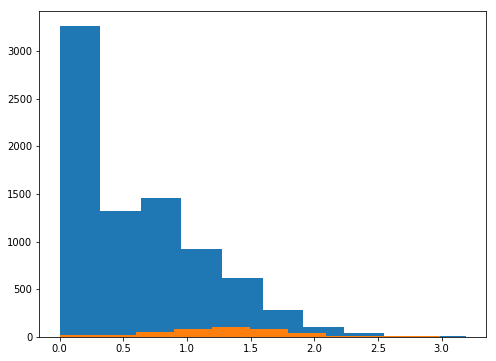

In [46]:
# some extremely large number of mosquito counts in the data. 
# To properly visualize the distribution, logarithm was taken prior to plot
fig, ax = plt.subplots(1,figsize = (8,6))
ax.hist(np.log10(traps.NumMosquitos[traps.WnvPresent==0]))
#plt.hold('on')
ax.hist(np.log10(traps.NumMosquitos[traps.WnvPresent==1]))
fig.savefig('NumMosquitos.jpg')

### 3.1.2 Date

In [9]:
traps.Date = pd.to_datetime(traps.Date)
X['Month'] = [x.week for x in traps.Date]
X['Year'] = [x.year for x in traps.Date]
X['Day'] = [x.dayofyear for x in traps.Date]

### 3.1.2 Trap_id
Trap T234 wasn't seen in the training set and it has 760 related records (7% in total) in the test set. 
Need to infer this trap's information based on geographical location later. For now, trap_id is treated as categorical variables and transform this variable with one-hot encoding 

In [10]:
X['Latitude'] = traps.Latitude
X['Longitude'] = traps.Longitude

In [11]:
from math import sin, cos, sqrt, atan2, radians
def distance_coordinate(lat1,lon1,lat2,lon2):
    # calculate the distance between 2 gps coordinate based on haver sin algorithm, resulting distance as km
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [12]:
def distance_matrix(target_train, target_test):
    # create distance matrix between target_train and target_test
    # target_test is observations (rows)
    # target_train is features (columns)
    
    tmp_train  = target_train[['Date','Trap','Latitude','Longitude']].groupby(['Trap','Latitude','Longitude']).count().reset_index()
    tmp_test = target_test[['Date','Trap','Latitude','Longitude']].groupby(['Trap','Latitude','Longitude']).count().reset_index()
#    target_combined = pd.concat((tmp2, pd.get_dummies(tmp.Trap, prefix='Trap')),axis=1)

    lamda = 1/3
    dist_mat = np.zeros((tmp_test.shape[0], tmp_train.shape[0]))
    
    for i, trap_loc in enumerate(tmp_test.Trap):
        lat1, lon1 = tmp_test[['Latitude','Longitude']].loc[i]
        
        for j, value in enumerate(tmp_train.Trap):        
            lat2, lon2 = tmp_train[['Latitude','Longitude']].iloc[j]
            dist = distance_coordinate(radians(lat1),radians(lon1),radians(lat2),radians(lon2))
           # dist_mat[i,j]= dist
            dist_mat[i,j]= 2/(1+np.exp(lamda*dist))
                  
    
    target_combine = pd.concat((tmp_test,pd.DataFrame(data=dist_mat, columns = tmp_train.Trap)), axis = 1)
    target_combine = target_combine.drop('Date', axis=1)
    target_combine.columns=pd.io.parsers.ParserBase({'names':target_combine.columns})._maybe_dedup_names(target_combine.columns)
    return target_combine


In [13]:
dist_mat = distance_matrix(traps, traps)
X['Trap_id'] = traps.Trap.astype('category')
X = X.merge(dist_mat, left_on=['Trap_id','Latitude','Longitude'], right_on=['Trap','Latitude','Longitude'], how='left')
X = X.drop(['Trap','Trap_id'], axis = 1)

In [14]:
dist_mat.head()

,Trap,Latitude,Longitude,T001,T002,T003,T004,T005,T006,T007,...,T230,T231,T232,T233,T235,T236,T237,T238,T900,T903
0,T001,41.953705,-87.733974,1.000000,0.272162,0.637080,0.746156,0.446794,0.198287,0.280336,...,0.252401,0.191030,0.170459,0.104153,0.001485,0.276805,0.000648,0.001147,0.024548,0.008689
1,T002,41.954690,-87.800991,0.272162,1.000000,0.446573,0.370494,0.610131,0.420308,0.300888,...,0.191767,0.039267,0.036490,0.227412,0.000566,0.309217,0.000401,0.000742,0.140917,0.053905
2,T003,41.964242,-87.757639,0.637080,0.446573,1.000000,0.869886,0.549887,0.378477,0.468542,...,0.194747,0.130176,0.084044,0.203892,0.000786,0.467876,0.000395,0.000712,0.048913,0.016563
3,T004,41.962728,-87.748367,0.746156,0.370494,0.869886,1.000000,0.504465,0.312015,0.419038,...,0.202967,0.159701,0.105065,0.168538,0.000927,0.415825,0.000438,0.000784,0.037918,0.012884
4,T005,41.942114,-87.776385,0.446794,0.610131,0.549887,0.504465,1.000000,0.265863,0.244721,...,0.361091,0.060245,0.079638,0.131638,0.001224,0.248064,0.000772,0.001416,0.066293,0.026699


/home/ying/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """Entry point for launching an IPython kernel.


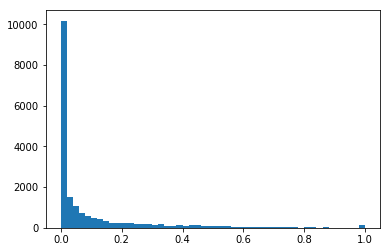

In [15]:
plt.hist(np.array(dist_mat.iloc[:,4:]).flatten(1),50);

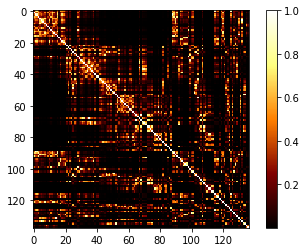

In [16]:
fig, ax = plt.subplots(1)
comap = ax.imshow(np.array(dist_mat.iloc[:,4:]), cmap ='afmhot')
fig.colorbar(comap, ax=ax)
#fig.savefig('distance_matrix_2.jpeg')

### 3.1.3 Species
Since Culex is the major vector of WNV, the test if probably based on the presence of female Culex in the trap. <br>
There're several sub-species and are they equally guilty?
- In the training data, the rare sub-species are not ineffected. This can be caused by less representation in the dataset, but in here I will group them together as one category, because their differences can't be derived by this dataset.
- The P/R mix seems not related to specific date or trap. It might be the labs can't separate this two species or it's a hybrid of two sub-species

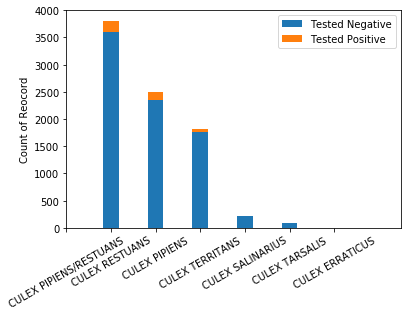

In [17]:
traps['Species_cat']= traps.Species.astype('category')
N = 7
species = traps.Species_cat.value_counts().keys()
pos_species = traps.Species_cat.loc[traps.WnvPresent ==1].value_counts()
neg_species = traps.Species_cat.loc[traps.WnvPresent ==0].value_counts()

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

#fig, ax = plt.subplots(1, figsize =(8,8))
p1 = plt.bar(ind, neg_species, width,)
p2 = plt.bar(ind, pos_species, width, bottom=neg_species)
plt.ylabel('Count of Reocord')
plt.xticks(ind-1, species,rotation=30)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Tested Negative', 'Tested Positive'))

plt.show()
fig.savefig('Species_bar.jpg',bbox_inches='tight')

In [18]:
X['Species'] = traps.Species

In [19]:
# Simplify the naming of species
X['Species'] = X['Species'].replace('CULEX PIPIENS/RESTUANS', 'P/R')
X['Species'] = X['Species'].replace('CULEX RESTUANS', 'R')
X['Species'] = X['Species'].replace('CULEX PIPIENS', 'P')
X['Species'] = X['Species'].replace('CULEX TERRITANS', 'Others')
X['Species'] = X['Species'].replace('CULEX SALINARIUS', 'Others')
X['Species'] = X['Species'].replace('CULEX TARSALIS', 'Others')
X['Species'] = X['Species'].replace('CULEX ERRATICUS', 'Others')

In [20]:
X.Species.value_counts()

P/R       3826
R         2393
P         1950
Others     306
Name: Species, dtype: int64

In [21]:
X = pd.concat((X, pd.get_dummies(X['Species'], drop_first=True, prefix='Species')),axis=1)
X = X.drop('Species', axis = 1)

### 3.1.4 Coordinate (Latitude and Longitude)

In [22]:
X['Latitude'] = traps.Latitude
X['Longitude'] = traps.Longitude

## 3.2 Features from weather
Data from station2 has a lot of missing data. Here I use the weather data from station 1 for the entire area.

In [23]:
weather.keys()

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [24]:
# relative humidity calculator (unit: percentage)
def relative_humidity(T_dry, T_wet, SP):
    T_dry = (T_dry-32) * 5/9 # adjusting for temperature unit
    T_wet = (T_wet-32) * 5/9
    e_d = 6.112*np.exp(17.502*T_dry/(240.97+T_dry))
    e_w = 6.112*np.exp(17.502*T_wet/(240.97+T_wet))
    A = 0.00066*(1+0.00115*T_wet)
    P = 33.8639*SP # convert inch of mercury to pascol
    Hr = (e_w-A*P*(T_dry-T_wet))/e_d*100
    return Hr


In [25]:
weather = weather.replace('M', np.NaN)
weather = weather.replace('-', np.NaN)
weather = weather.replace('T', np.NaN)
weather = weather.replace(' T', np.NaN)
weather = weather.replace('  T', np.NaN)

In [26]:
weather_stn1 = weather[weather['Station']==1]
weather_stn1 = weather_stn1.drop(['Station', 'Water1', 'Heat', 'Cool', 'CodeSum','SnowFall','Depth','Sunrise','Sunset'], axis = 1)

In [27]:
weather_stn1.Date = pd.to_datetime(weather_stn1.Date)
weather_stn1['Month'] = [x.week for x in weather_stn1.Date]
weather_stn1['Year'] = [x.year for x in weather_stn1.Date]

In [28]:
weather_stn1 = weather_stn1.apply(pd.to_numeric).drop(['Date'], axis = 1).reset_index(drop = True)

In [29]:
# refine features
# adding temperature difference
weather_stn1['Tdif'] = weather_stn1.Tmax - weather_stn1.Tmin
weather_stn1 = weather_stn1.drop(['Tmax','Tmin'], axis =1)

# adding relative humidity (100)
weather_stn1['RH'] = [relative_humidity(weather_stn1.Tavg.loc[i],
                                        weather_stn1.WetBulb.loc[i],
                                        weather_stn1.StnPressure.loc[i]) 
                      for i,x in enumerate(weather_stn1.Tavg)]


weather_stn1['ResultDir'] = [np.cos(radians(x)) for x in weather_stn1['ResultDir']]

weather2 = weather_stn1.groupby(['Year','Month']).mean().reset_index()
weather2 = weather2.drop(['DewPoint','WetBulb','SeaLevel','AvgSpeed'],axis =1)

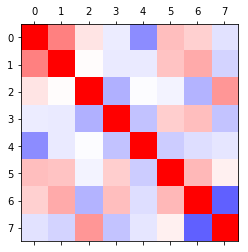

In [31]:
fig, ax = plt.subplots(1)
ax.matshow(weather2.iloc[:,2:].corr(),
           cmap = 'bwr',
           vmin = -1, vmax =1)
#ax.colorbar()

#fig.savefig('weather_fmat2.jpg')

In [32]:
def weather_delay(weather_in, N_delay):
    '''delay the weather feature for N weeks. '''  
        
    weather_tmp = weather_in.copy(deep = True)  
    
    weather_tmp.Month = weather_tmp.Month+N_delay

    col_name = [x+'_'+str(N_delay)+'w' for i,x in enumerate(list(weather_in.keys()))]
    weather_tmp.columns = col_name
    weather_tmp.columns.values[0:2]=('Year','Month')
        
    # handle missing rows
    weather_tmp = weather_tmp.shift(N_delay)
    for i in range(N_delay):
        weather_tmp.iloc[i,:] = weather_tmp.iloc[N_delay,:]
        weather_tmp.Month.iloc[i] = weather_tmp.Month.iloc[N_delay]-(N_delay-i)
    
    return weather_tmp  
        #rename colomns

In [33]:
X = X.merge(weather2, on=['Year','Month'],how='left')
N_month = 4
for i in range(1, N_month+1):
    X = X.merge(weather_delay(weather2,i), on=['Year','Month'], how='left')

## 3.3 Target

In [34]:
y = (traps.WnvPresent>0).astype(int)

# 4. Model

In [35]:
X= X.apply(pd.to_numeric)

### Feature Normalization

In [36]:
# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
ss = StandardScaler()
X_scale = ss.fit_transform(X)

### Adjusting imbalance using SMOTE
Model is overfitting with smote, not going to use this


In [37]:
from imblearn.over_sampling import SMOTE 
from collections import Counter
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_scale, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 8018, 1: 8018})


### Train/test split

In [38]:
# training testing split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=21)

## 4.1 Model Selection

### 4.1.1 SVM

In [39]:
from sklearn.svm import SVC
svc = SVC(probability=True, C=1)
svc.fit(X_train, y_train)
yhat = svc.predict_proba(X_test)
roc_auc_score(y_test, yhat[:,1])

0.7954616167901793

### 4.1.2 Logistic

In [40]:
from sklearn.linear_model import LogisticRegression
lor = LogisticRegression(penalty='l1', C =10)
lor.fit(X_train, y_train)
yhat = lor.predict_proba(X_test)
roc_auc_score(y_test, yhat[:,1])

0.8315961418792782

### 4.1.3 AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
yhat = abc.predict_proba(X_test)
roc_auc_score(y_test, yhat[:,1])

0.8196137636476777

### 4.1.4 XGBoost

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.125)
xgb.fit(X_train, y_train)
yhat = xgb.predict_proba(X_test)
roc_auc_score(y_test, yhat[:,1])

0.8526722577360413

### 4.1.5 Summarize

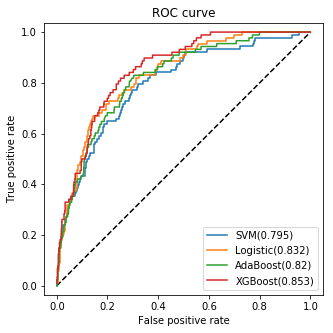

In [43]:
f, ax = plt.subplots(1,1,figsize= (5,5))
plt.plot([0, 1], [0, 1], 'k--')
fpr, tpr, _ = roc_curve(y_test,svc.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='SVM('+str(round(roc_auc_score(y_test, svc.predict_proba(X_test)[:,1]),3))+')')

fpr, tpr, _ = roc_curve(y_test,lor.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Logistic('+str(round(roc_auc_score(y_test, lor.predict_proba(X_test)[:,1]),3))+')')

fpr, tpr, _ = roc_curve(y_test,abc.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='AdaBoost('+str(round(roc_auc_score(y_test, abc.predict_proba(X_test)[:,1]),3))+')')

fpr, tpr, _ = roc_curve(y_test,xgb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='XGBoost('+str(round(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]),3))+')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.xlim(0,1)
#plt.xlim(xmin=0, xmax=1)
plt.axis('equal')

plt.show()
f.savefig('roc.jpg')

## 4.2 Fine-tune the hyper-parameters

In [44]:
## tuning svm
from sklearn.model_selection import GridSearchCV
Cs = np.logspace(-3,3,7)
parameters = {'C':Cs}
grid = GridSearchCV(svc, parameters,
                   return_train_score=True,
                   scoring='roc_auc')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.762
best parameters: {'C': 0.1}
test-set score: 0.791


In [ ]:
## tuning logistic regression
from sklearn.model_selection import GridSearchCV
Cs = np.logspace(-3,5,9)
parameters = {'C':Cs}
grid = GridSearchCV(LogisticRegression(penalty='l2'), parameters,
                   return_train_score=True,
                   scoring='roc_auc')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

In [ ]:
## tuning xgb
from sklearn.model_selection import GridSearchCV
lr = np.linspace(0,0.5,9)
parameters = {'learning_rate':lr}
grid = GridSearchCV(XGBClassifier(n_estimators=100), parameters,
                   return_train_score=True,
                   scoring='roc_auc')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

# 5. Visualization

## 5.1 Features of Model

### Feature importance of XGB

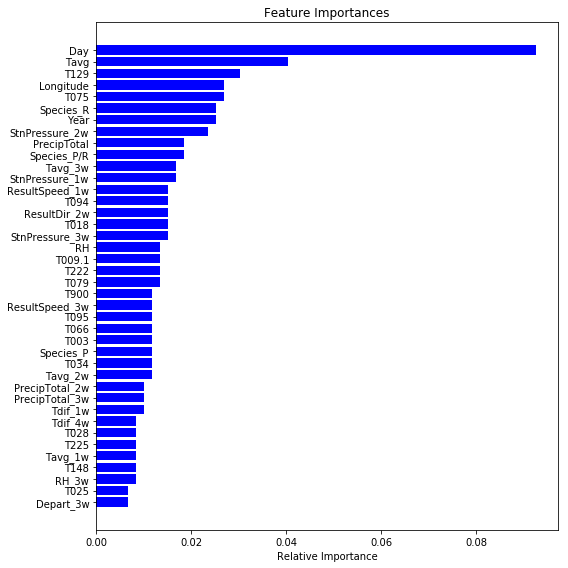

In [47]:
features = X.keys()
importances = xgb.feature_importances_
indices = np.argsort(importances)

f, ax = plt.subplots(1, figsize = (8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices[-40:])), importances[indices[-40:]], color='b', align='center')
plt.yticks(range(len(indices[-40:])), [features[i] for i in indices[-40:]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

### Feature importance of Logistic regression

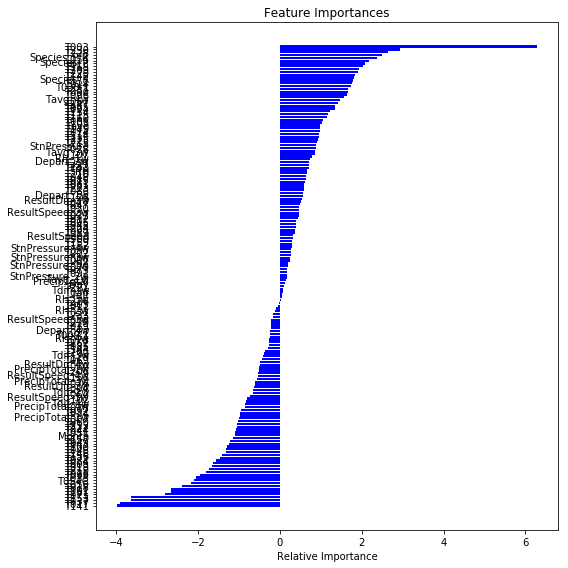

In [50]:
features = X.keys()
importances = lor.coef_[0]
indices = np.argsort(importances)
idx = abs(importances[indices])> np.mean(importances)
#idx = abs(importances[indices])>2 

#idx = abs(importances[indices])> np.median(abs(importances)) 

f, ax = plt.subplots(1, figsize = (8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices[idx])), importances[indices][idx], color='b', align='center')
plt.yticks(range(len(indices[idx])), features[indices][idx])
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.show()

## 5.2 Feature importance breakdown

In [51]:
features = X.keys()
importances = lor.coef_[0]
#importances = xgb.feature_importances_

### Species

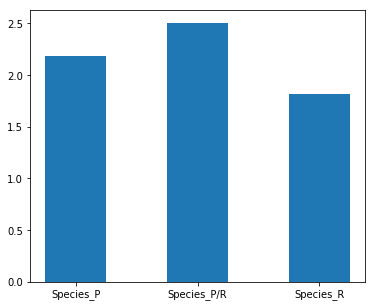

In [52]:
# plot Species
idx = ['Species' in x for x in features]
fig, ax = plt.subplots(1, figsize=(6,5))
plt.bar(features[idx],importances[idx], width =0.5)
fig.savefig('Species.jpg')

### Weather

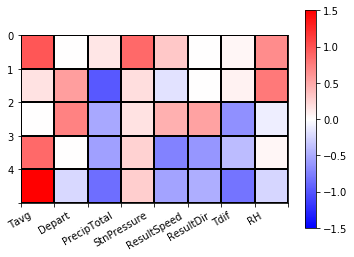

In [54]:
fig, ax = plt.subplots(1)
idx = features[-40:]
comap = ax.imshow(importances[-40:].reshape(5,8), cmap = 'bwr', vmax = 1.5, vmin =-1.5)
#comap = ax.imshow(importances[-65:].reshape(5,8), cmap = 'OrRd', vmax = 0, vmin = 0.01)

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 8, 1))
ax.set_yticks(np.arange(-.5, 5, 1))
ax.set_xticklabels(features[-40:-32], rotation=30)
ax.set_yticklabels(np.arange(0, 5, 1))
ax.grid(color='k', linestyle='-', linewidth=2)
fig.colorbar(comap, ax=ax)

fig.savefig('weather.jpg')

### Location

In [56]:
idx = [i for i,x in enumerate(features) if (x[0]=='T') & (x[1].isnumeric())]
#importances = xgb.feature_importances_
importances = lor.coef_[0]
importances[idx];

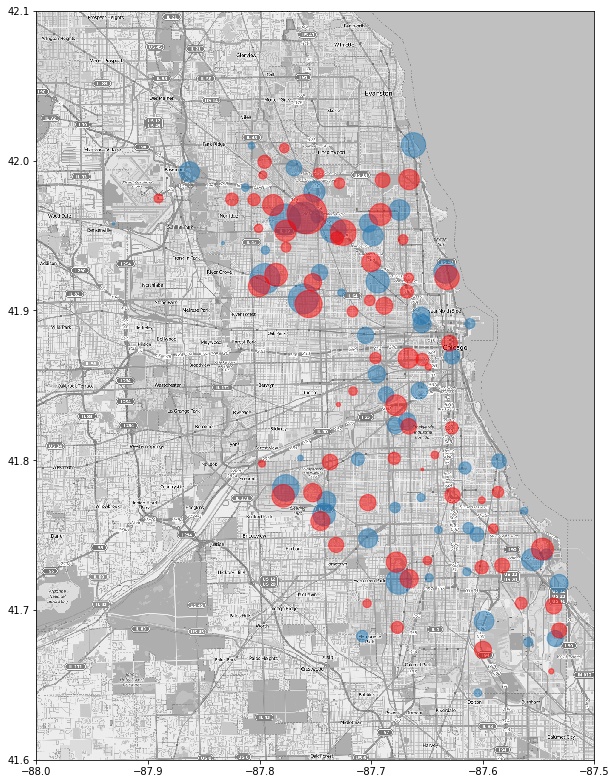

In [57]:
from pylab import *
mapdata = np.loadtxt("../SparkBeyond/data/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../SparkBeyond/data/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Trap','Longitude', 'Latitude']].groupby(['Trap','Longitude', 'Latitude']).count().reset_index()
locations['Importance'] = importances[idx]

neg_idx = locations.Importance<0

plt.scatter(locations[neg_idx].iloc[:,1], locations[neg_idx].iloc[:,2], alpha = 0.5, s =250*np.abs(locations[neg_idx].iloc[:,3]))
#plt.savefig('heatmap.png')

pos_idx = locations.Importance>0

plt.scatter(locations[pos_idx].iloc[:,1], locations[pos_idx].iloc[:,2],color='r', alpha = 0.5, s =250*locations[pos_idx].iloc[:,3])
#plt.savefig('heatmap.png')

fig.savefig('Location.jpg')